In [1]:
import pymysql
import pandas as pd

In [2]:
order_col_names = ['id', 'time', 
                   'ask_1', 'ask_1_amt', 'bid_1', 'bid_1_amt', 'ask_2', 'ask_2_amt', 'bid_2', 'bid_2_amt', 
                   'ask_3', 'ask_3_amt', 'bid_3', 'bid_3_amt', 'ask_4', 'ask_4_amt', 'bid_4', 'bid_4_amt', 
                   'ask_5', 'ask_5_amt', 'bid_5', 'bid_5_amt']
order_col_names_2 = ['id', 'time', 
                      'ask_1', 'ask_1_amt', 'ask_1_before', 'bid_1', 'bid_1_amt', 'bid_1_before', 
                      'ask_2', 'ask_2_amt', 'ask_2_before', 'bid_2', 'bid_2_amt', 'bid_2_before', 
                      'ask_3', 'ask_3_amt', 'ask_3_before', 'bid_3', 'bid_3_amt', 'bid_3_before', 
                      'ask_4', 'ask_4_amt', 'ask_4_before', 'bid_4', 'bid_4_amt', 'bid_4_before', 
                      'ask_5', 'ask_5_amt', 'ask_5_before', 'bid_5', 'bid_5_amt', 'bid_5_before']
trans_col_names = ['id', 'time', 'price', 'amount']

# def get_col_names(cur, table_name):
#     ''' get col namess
#     '''
#     q = f'''DESCRIBE {table_name}'''
#     cur.execute(q)
#     cols = cur.fetchall()
    
#     return [col[0] for col in cols]

def get_dbs(cur):
    q = '''SHOW DATABASES'''
    cur.execute(q)
    res = cur.fetchall()
    
    return [r[0] for r in res]

def get_table_names(cur):
    q = '''SHOW TABLES'''
    cur.execute(q)
    tables = cur.fetchall()
    
    return [t[0] for t in tables]

def read_table_by_info(cur, date, table_type, code):
    q = f'''SELECT * FROM {date}_{table_type}_{code}'''
    cur.execute(q)
    rows = cur.fetchall()
    
    return rows

def read_table_by_name(cur, table_name):
    q = f'''SELECT * FROM {table_name}'''
    cur.execute(q)
    rows = cur.fetchall()
    
    return rows

def extract_combinations(tables):
    combi = []
    for col in zip(*[table.split('_') for table in tables]):
        combi.append(set(col))
    
    return combi

def get_order_tables_names(cur):
    tables = get_table_names(cur)
    return [t for t in tables if 'order' in t]

def get_trans_tables_names(cur):
    tables = get_table_names(cur)
    return [t for t in tables if 'trans' in t]

def get_table_df(table_name):
    rows = read_table_by_name(table_name)
    df = pd.DataFrame(rows)
    if 'order' in table_name:
        if len(df.columns) == len(order_col_names):
            df.columns = order_col_names
        else:
            df.columns = order_col_names_2
        df.drop(columns='id', inplace=True)
        
    elif 'trans' in table_name:
        df.columns = trans_col_names
        df.drop(columns='id', inplace=True)
    
    return df

# for trans
def get_trans_vpin(trans_df, max_capa=20000, window=5):
    '''
    maybe need cut out by time (0900~1520)
    proxy of PIN, volatility
    '''
    
    amounts = trans_df['amount']
    cur_i, buy, sell, b_cnt, s_cnt = 1, 0, 0, 0, 0
    buckets = []

    # vol buckets
    while len(trans_df) > cur_i:
        if amounts[cur_i] >=0:
            buy += amounts[cur_i]
            b_cnt += 1
        else:
            sell += amounts[cur_i]
            s_cnt += 1

        if buy + (-sell) >= max_capa:
            buckets.append((cur_i, buy, sell, b_cnt, s_cnt))
            buy, sell, b_cnt, s_cnt = 0, 0, 0, 0
        cur_i += 1

    vol_buckets = pd.DataFrame(buckets)
    vol_buckets.columns = ['trans_idx', 'buy', 'sell', 'buy_cnt', 'sell_cnt']
    
    # vpin
#     vpin = abs(vol_buckets['buy'].rolling(window).sum() + vol_buckets['sell'].rolling(window).sum()) / (max_capa * window)
    vpin = abs(vol_buckets['buy'] + vol_buckets['sell']) / (vol_buckets['buy'] - vol_buckets['sell'])

    vol_buckets['vpin'] = vpin
    
    return vol_buckets

# for order
def get_sobi(df):
    vol_ask = df[f'ask_1_amt'] + df[f'ask_2_amt'] + df[f'ask_3_amt'] + df[f'ask_4_amt'] + df[f'ask_5_amt']
    vol_bid = df[f'bid_1_amt'] + df[f'bid_2_amt'] + df[f'bid_3_amt'] + df[f'bid_4_amt'] + df[f'bid_5_amt']

    tmp_ask = [abs(df[f'ask_{i}'] * df[f'ask_{i}_amt']) for i in range(1, 6)]
    tmp_bid = [abs(df[f'bid_{i}'] * df[f'bid_{i}_amt']) for i in range(1, 6)]

    total_ask = tmp_ask[0] + tmp_ask[1] + tmp_ask[2] + tmp_ask[3] + tmp_ask[4]
    total_bid = tmp_bid[0] + tmp_bid[1] + tmp_bid[2] + tmp_bid[3] + tmp_bid[4]

    ask_vwap = total_ask / vol_ask
    bid_vwap = total_bid / vol_bid
    
    
    mid_vwap = (ask_vwap + bid_vwap) / 2
    mid_price = (abs(df['ask_1']) * df['ask_1_amt'] + abs(df['bid_1']) * df['bid_1_amt']) / (df['bid_1_amt'] + df['ask_1_amt'])
    
    return mid_vwap, mid_price

# for candle

In [4]:
conn = pymysql.connect(user='root', passwd='0000', host='localhost', db='kiwoom')
cur = conn.cursor()

In [5]:
dbs = get_dbs(cur)
tables = get_table_names(cur)
combis = extract_combinations(tables)
# col_names = get_col_names(cur, tables[0])
trans_tables = get_trans_tables_names(cur)
order_tables = get_order_tables_names(cur)

In [20]:
df = get_table_df(order_tables[5])

In [21]:
df

,time,ask_1,ask_1_amt,bid_1,bid_1_amt,ask_2,ask_2_amt,bid_2,bid_2_amt,ask_3,...,bid_3,bid_3_amt,ask_4,ask_4_amt,bid_4,bid_4_amt,ask_5,ask_5_amt,bid_5,bid_5_amt
0,2022-08-09 08:57:52,3245,1025,-3240,379,3255,1,-3235,634,3265,...,-3230,563,0,0,0,0,0,0,0,0
1,2022-08-09 08:59:09,3245,1025,-3240,329,3255,1,-3235,634,3265,...,-3230,563,0,0,0,0,0,0,0,0
2,2022-08-09 08:59:09,3245,1025,-3240,329,3255,1,-3235,634,3265,...,-3230,563,0,0,0,0,0,0,0,0
3,2022-08-09 08:59:12,3245,1025,-3240,829,3255,1,-3235,634,3265,...,-3230,563,0,0,0,0,0,0,0,0
4,2022-08-09 08:59:18,3245,1025,-3240,829,3255,1,-3235,634,3265,...,-3230,563,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,2022-08-09 15:29:58,3325,47,3320,952,3330,100,3315,3350,3335,...,3310,929,0,0,0,0,0,0,0,0
2914,2022-08-09 15:29:59,3325,117,3320,952,3330,100,3315,3350,3335,...,3310,929,0,0,0,0,0,0,0,0
2915,2022-08-09 15:30:06,3325,17,3320,952,3330,100,3315,3350,3335,...,3310,929,0,0,0,0,0,0,0,0
2916,2022-08-09 15:30:07,3325,17,3320,952,3330,100,3315,3350,3335,...,3310,929,3340,3399,3305,823,3345,480,3300,4694


In [22]:
vb = get_trans_vpin(df, max_capa=5000, window=1)

KeyError: 'amount'

<BarContainer object of 33 artists>

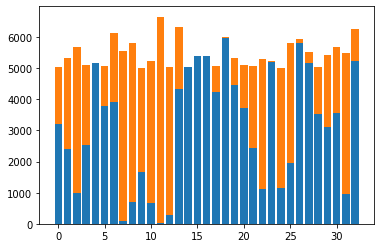

In [23]:
import numpy as np
import matplotlib.pyplot as plt

buckets = np.array(vb)
plt.bar(range(len(buckets)), buckets[:, 1])
plt.bar(range(len(buckets)), -buckets[:, 2], bottom=buckets[:, 1])


<BarContainer object of 33 artists>

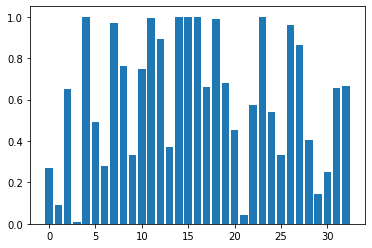

In [24]:
plt.bar(range(len(vb)), vb['vpin'])

In [25]:
vb[vb['vpin']>.7]

,trans_idx,buy,sell,buy_cnt,sell_cnt,vpin
4,118,5173,0,5,0,1.000000
7,189,83,-5478,2,5,0.970149
8,207,699,-5122,9,9,0.759835
10,277,663,-4570,26,10,0.746608
11,288,26,-6627,5,6,0.992184
12,307,274,-4764,8,11,0.891227
14,340,5024,0,9,0,1.000000
15,350,5396,0,10,0,1.000000
16,358,5382,0,8,0,1.000000
18,424,5969,-35,26,1,0.988341


In [26]:
import matplotlib.pyplot as plt

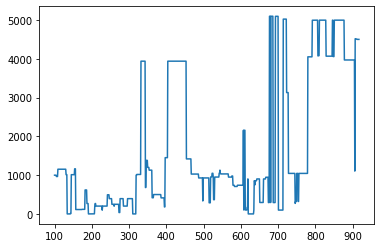

In [28]:
plt.plot(abs(df['ask_2_amt'][100:-2000]))

In [29]:
df

,time,ask_1,ask_1_amt,bid_1,bid_1_amt,ask_2,ask_2_amt,bid_2,bid_2_amt,ask_3,...,bid_3,bid_3_amt,ask_4,ask_4_amt,bid_4,bid_4_amt,ask_5,ask_5_amt,bid_5,bid_5_amt
0,2022-08-09 08:57:52,3245,1025,-3240,379,3255,1,-3235,634,3265,...,-3230,563,0,0,0,0,0,0,0,0
1,2022-08-09 08:59:09,3245,1025,-3240,329,3255,1,-3235,634,3265,...,-3230,563,0,0,0,0,0,0,0,0
2,2022-08-09 08:59:09,3245,1025,-3240,329,3255,1,-3235,634,3265,...,-3230,563,0,0,0,0,0,0,0,0
3,2022-08-09 08:59:12,3245,1025,-3240,829,3255,1,-3235,634,3265,...,-3230,563,0,0,0,0,0,0,0,0
4,2022-08-09 08:59:18,3245,1025,-3240,829,3255,1,-3235,634,3265,...,-3230,563,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,2022-08-09 15:29:58,3325,47,3320,952,3330,100,3315,3350,3335,...,3310,929,0,0,0,0,0,0,0,0
2914,2022-08-09 15:29:59,3325,117,3320,952,3330,100,3315,3350,3335,...,3310,929,0,0,0,0,0,0,0,0
2915,2022-08-09 15:30:06,3325,17,3320,952,3330,100,3315,3350,3335,...,3310,929,0,0,0,0,0,0,0,0
2916,2022-08-09 15:30:07,3325,17,3320,952,3330,100,3315,3350,3335,...,3310,929,3340,3399,3305,823,3345,480,3300,4694


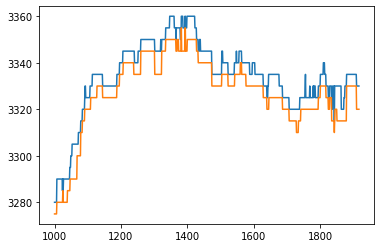

In [30]:
plt.plot(df['ask_1'][1000:-1000])
plt.plot(df['bid_1'][1000:-1000])

In [235]:
get_table_names(cur)

['20220808_order_005380',
 '20220808_order_005930',
 '20220808_order_066570',
 '20220808_trans_005380',
 '20220808_trans_005930',
 '20220808_trans_066570',
 '20220809_order_001770',
 '20220809_order_002290',
 '20220809_order_002690',
 '20220809_order_005670',
 '20220809_order_008370',
 '20220809_order_008470',
 '20220809_order_009140',
 '20220809_order_010420',
 '20220809_order_010640',
 '20220809_order_011420',
 '20220809_trans_001770',
 '20220809_trans_002290',
 '20220809_trans_002690',
 '20220809_trans_005670',
 '20220809_trans_008370',
 '20220809_trans_008470',
 '20220809_trans_009140',
 '20220809_trans_010420',
 '20220809_trans_010640',
 '20220809_trans_011420',
 '20220810_order_001770',
 '20220810_order_002290',
 '20220810_order_002690',
 '20220810_order_005670',
 '20220810_order_008370',
 '20220810_order_008470',
 '20220810_order_009140',
 '20220810_order_010420',
 '20220810_order_010640',
 '20220810_order_011420',
 '20220810_trans_001770',
 '20220810_trans_002290',
 '20220810_t

In [31]:
trans = get_table_df('20220818_trans_001770')

In [32]:
order = get_table_df('20220818_order_001770')

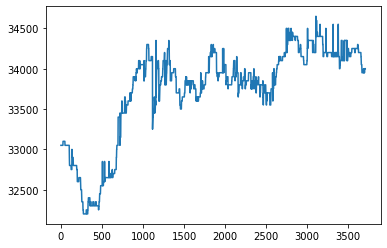

In [33]:
plt.plot(abs(order['bid_1']))

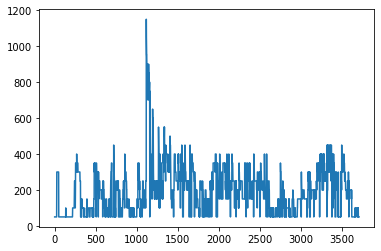

In [34]:
plt.plot(abs(order['ask_1'])-abs(order['bid_1']))